### Team Project

### Product Recommendator Based on Amazon Reviews

In [1]:
#import statements
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

In [2]:
spark = SparkSession.builder.enableHiveSupport().appName('AmazonReviews').getOrCreate()
sc = spark.sparkContext

In [3]:
#check to see if thata is available in HDFS
!hdfs dfs -ls /user/sijieli0801/data

Java HotSpot(TM) 64-Bit Server VM warning: ignoring option MaxPermSize=512M; support was removed in 8.0
Found 4 items
-rw-r--r--   3 sijieli0801 sijieli0801 32072979001 2022-04-27 17:18 /user/sijieli0801/data/kcore_5.json
-rw-r--r--   3 sijieli0801 sijieli0801 10597681037 2022-04-27 14:16 /user/sijieli0801/data/kcore_5.json.gz
-rw-r--r--   3 sijieli0801 sijieli0801 10544467811 2022-04-27 17:10 /user/sijieli0801/data/metadata.json
-rw-r--r--   3 sijieli0801 sijieli0801  3358565493 2022-04-27 14:25 /user/sijieli0801/data/metadata.json.gz


In [4]:
%time scores = sc.textFile("/user/sijieli0801/data/kcore_5.json")

CPU times: user 3.56 ms, sys: 521 µs, total: 4.08 ms
Wall time: 603 ms


In [5]:
%time scores = spark.read.json("/user/sijieli0801/data/kcore_5.json")

CPU times: user 5.33 ms, sys: 4.18 ms, total: 9.5 ms
Wall time: 30.8 s


In [6]:
scores.show(2)

+----------+-------+-------+--------------------+-----------+--------------+------------+--------------------+--------------+
|      asin|helpful|overall|          reviewText| reviewTime|    reviewerID|reviewerName|             summary|unixReviewTime|
+----------+-------+-------+--------------------+-----------+--------------+------------+--------------------+--------------+
|0000013714| [0, 0]|    4.0|We use this type ...| 12 3, 2013| ACNGUPJ3A3TM9|         GCM|         Nice Hymnal|    1386028800|
|0000013714| [2, 3]|    5.0|I bought this for...|09 13, 2009|A2SUAM1J3GNN3B| J. McDonald|Heavenly Highway ...|    1252800000|
+----------+-------+-------+--------------------+-----------+--------------+------------+--------------------+--------------+
only showing top 2 rows



In [7]:
scores.printSchema()

root
 |-- asin: string (nullable = true)
 |-- helpful: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- overall: double (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- reviewTime: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- unixReviewTime: long (nullable = true)



In [8]:
%time metadata = spark.read.json("/user/sijieli0801/data/metadata.json")

CPU times: user 3.23 ms, sys: 1.43 ms, total: 4.66 ms
Wall time: 6.5 s


In [9]:
metadata.show(2)

+---------------+----------+-----+--------------------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+
|_corrupt_record|      asin|brand|          categories|         description|               imUrl|price|             related|           salesRank|               title|
+---------------+----------+-----+--------------------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+
|           null|0001048791| null|           [[Books]]|                null|http://ecx.images...| null|                null|[,,,,, 6334800,,,...|The Crucible: Per...|
|           null|0000143561| null|[[Movies & TV, Mo...|3Pack DVD set - I...|http://g-ecx.imag...|12.99|[, [B0036FO6SI, B...|[,,,,,,,,,,,,,,,,...|Everyday Italian ...|
+---------------+----------+-----+--------------------+--------------------+--------------------+-----+--------------------+--------------------+--------------------

In [10]:
metadata.printSchema()

root
 |-- _corrupt_record: string (nullable = true)
 |-- asin: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- categories: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: string (containsNull = true)
 |-- description: string (nullable = true)
 |-- imUrl: string (nullable = true)
 |-- price: double (nullable = true)
 |-- related: struct (nullable = true)
 |    |-- also_bought: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- also_viewed: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- bought_together: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- buy_after_viewing: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |-- salesRank: struct (nullable = true)
 |    |-- Appliances: long (nullable = true)
 |    |-- Arts, Crafts & Sewing: long (nullable = true)
 |    |-- Automotive: long

## HIVE table

In [11]:
from pyspark.sql import HiveContext
hive_context = HiveContext(sc)

In [12]:
hive_context.sql("use sijieli");

In [13]:
hive_context.sql("show tables").show();

+--------+---------------+-----------+
|database|      tableName|isTemporary|
+--------+---------------+-----------+
| sijieli| chicago_crimes|      false|
| sijieli|         crimes|      false|
| sijieli|       crimeviz|      false|
| sijieli|foodinspections|      false|
| sijieli|         scores|      false|
+--------+---------------+-----------+



In [14]:
scores.write.mode('overwrite').saveAsTable('scores')

In [15]:
#metadata.write.saveAsTable("metadata.product")

In [16]:
#metadata.write.mode('overwrite').saveAsTable('metadata')

In [42]:
import matplotlib.pyplot as plt
%matplotlib inline

In [18]:
#Approximate Count of asin(product)
from pyspark.sql.functions import approxCountDistinct

scores.select(approxCountDistinct("asin", rsd = 0.01)).show()

+---------------------------+
|approx_count_distinct(asin)|
+---------------------------+
|                    1574007|
+---------------------------+



In [19]:
#Find the number of missing values for each column
from pyspark.sql.functions import isnan, when, count, col
scores.select([count(when(scores[c].isNull(), c)).alias(c) for c in scores.columns]).show()

+----+-------+-------+----------+----------+----------+------------+-------+--------------+
|asin|helpful|overall|reviewText|reviewTime|reviewerID|reviewerName|summary|unixReviewTime|
+----+-------+-------+----------+----------+----------+------------+-------+--------------+
|   0|      0|      0|         0|         0|         0|      932551|      0|             4|
+----+-------+-------+----------+----------+----------+------------+-------+--------------+



In [20]:
#from pyspark.sql.functions import isnan, when, count, col
metadata.select([count(when(metadata[c].isNull(), c)).alias(c) for c in metadata.columns]).show()

+---------------+-------+-------+----------+-----------+-------+-------+-------+---------+-------+
|_corrupt_record|   asin|  brand|categories|description|  imUrl|  price|related|salesRank|  title|
+---------------+-------+-------+----------+-----------+-------+-------+-------+---------+-------+
|        8403388|1026700|7851678|   1096116|    4755417|1193791|4164158|3528377|  3254867|2377099|
+---------------+-------+-------+----------+-----------+-------+-------+-------+---------+-------+



## Join Score and Meta table

In [21]:
MainT = scores.join(metadata, scores.asin == metadata.asin, "inner").select(
    scores.asin, 
    scores.helpful,
    scores.overall, 
    scores.reviewText, 
    scores.reviewerID,
    metadata.categories,
    metadata.price,
    metadata.related,
    metadata.title
)

In [22]:
MainT.show(2)

+----------+-------+-------+--------------------+-------------+----------+-----+--------------------+---------------+
|      asin|helpful|overall|          reviewText|   reviewerID|categories|price|             related|          title|
+----------+-------+-------+--------------------+-------------+----------+-----+--------------------+---------------+
|0002216973| [1, 1]|    5.0|And to me, there'...|AESMLAZX4PI6L| [[Books]]| null|[, [0812823354, 0...|Red Adam's Lady|
|0002216973| [1, 1]|    5.0|From the dust jac...|AMVV8VYDTLA78| [[Books]]| null|[, [0812823354, 0...|Red Adam's Lady|
+----------+-------+-------+--------------------+-------------+----------+-----+--------------------+---------------+
only showing top 2 rows



In [23]:
MainT.createOrReplaceTempView("MainT")

## Plot "Review Count By Score Level"

In [24]:
reviewbyscore = MainT.select("reviewerID","overall").groupby("overall").count()

In [25]:
overall = [1,2,3,4,5]

In [26]:
reviewbyscore = reviewbyscore.toPandas()

In [27]:
reviewbyscore.head(5)

,overall,count
0,1.0,2039664
1,4.0,6763240
2,3.0,3101981
3,2.0,1674348
4,5.0,19702864


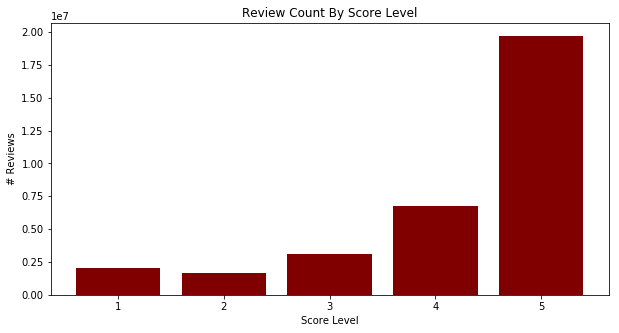

In [43]:
fig = plt.figure(figsize = (10, 5))
 
plt.bar("overall", "count",data = reviewbyscore,color ='maroon')

plt.xlabel("Score Level")
plt.ylabel("# Reviews")
plt.title("Review Count By Score Level")
plt.show()

In [30]:
import seaborn as sns

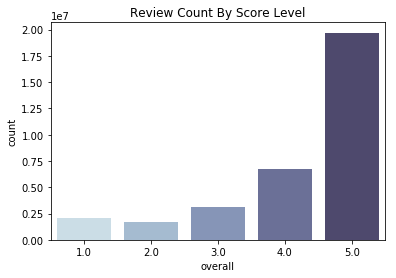

In [46]:
sns.set_palette("ch:s=.25,rot=-.25")
sns.barplot(x = "overall",
            y = "count",
            data = reviewbyscore).set(title='Review Count By Score Level')
plt.savefig('Review_Count_By_Score_Level.png')

## Plot "Top 10 count categories by scores level or median score level"

In [47]:
cat_top = MainT.select("categories","reviewerID").groupby(MainT.categories[0][0]).count().orderBy("count", ascending=False).limit(10)

In [48]:
cat_top = cat_top.toPandas()

In [49]:
cat_top

,categories[0][0],count
0,Books,9115768
1,Electronics,3398224
2,"Clothing, Shoes & Jewelry",2059979
3,Movies & TV,1989636
4,Home & Kitchen,1985213
5,Health & Personal Care,1468117
6,Cell Phones & Accessories,1297057
7,Apps for Android,1295382
8,Sports & Outdoors,1260001
9,CDs & Vinyl,1234729


In [50]:
# top 10 count categories
cat_top1 = MainT.select("categories","overall","reviewerID").groupby(MainT.categories[0][0],"overall").count().orderBy("count", ascending=False)

In [51]:
cat_top1 = cat_top1.toPandas()

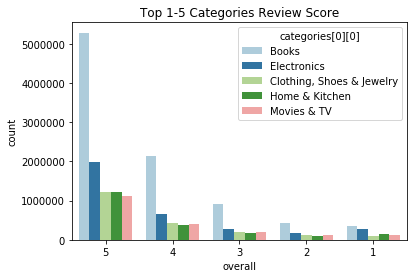

In [52]:
cat = ['Books','Electronics','Clothing, Shoes & Jewelry','Home & Kitchen','Movies & TV']
xorder = [5,4,3,2,1]
sns.set_palette("Paired")
ax = sns.barplot(x = "overall",
            y = "count",
            hue = "categories[0][0]",
            hue_order = cat,
            order = xorder,
            data = cat_top1).set(title='Top 1-5 Categories Review Score')
fig.savefig('Top1-5CategoriesReview core.png')

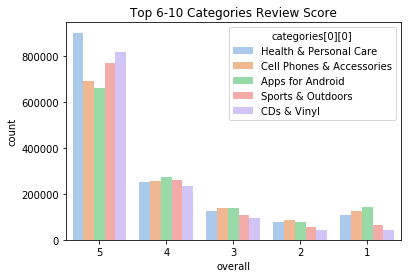

In [53]:
cat = ['Health & Personal Care','Cell Phones & Accessories','Apps for Android','Sports & Outdoors','CDs & Vinyl']
xorder = [5,4,3,2,1]
sns.set_palette("pastel")
ax = sns.barplot(x = "overall",
            y = "count",
            hue = "categories[0][0]",
            hue_order = cat,
            order = xorder,
            data = cat_top1).set(title='Top 6-10 Categories Review Score')
fig.savefig('Top6-10CategoriesReview core.png')